In [1]:
!pip install mlflow

     |████████████████████████████████| 16.5 MB 155 kB/s 
     |████████████████████████████████| 596 kB 43.8 MB/s 
     |████████████████████████████████| 210 kB 48.6 MB/s 
     |████████████████████████████████| 58 kB 6.1 MB/s 
     |████████████████████████████████| 79 kB 8.3 MB/s 
     |████████████████████████████████| 146 kB 55.0 MB/s 
     |████████████████████████████████| 181 kB 49.1 MB/s 
     |████████████████████████████████| 54 kB 2.8 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 75 kB 4.7 MB/s 
  Created wheel for databricks-cli: filename=databricks_cli-0.16.4-py3-none-any.whl size=106877 sha256=5e12ce229e5c0c5a5e0fff448182d6c3a23aa558b788f191749300c69796a69a
  Stored in directory: /root/.cache/pip/wheels/a2/a1/6d/fa1d22ea25ed8593887437fe1c7e00f6ef307fc240ccd4dc5c
Successfully built databricks-cli
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfu

In [2]:
## LIBRERIAS
from google.colab import drive, files
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mlflow
from keras import Model, Sequential
from keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, BatchNormalization, Rescaling
import random
import os
random.seed(1234)

In [3]:
## Cargamos Drive e importamos las imágenes de train y test
drive.mount('/content/drive')
!unzip "/content/drive/MyDrive/Colab/Sentinel2LULC_354.zip" -d "/content"
!unzip "/content/drive/MyDrive/Colab/Sentinel2LULC_Test.zip" -d "/content"

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: /content/Sentinel2LULC_354/15_ForestsOpEvNe_jpeg/15_ForestsOpEvNe_81.1__2527_3.4_(+68.4056309072,+27.9598835551)_FI_Lapland_Pohjois-Lappi_Ivalo.jpg  
  inflating: /content/Sentinel2LULC_354/15_ForestsOpEvNe_jpeg/15_ForestsOpEvNe_80.9__2833_1.7_(+55.6481165684,+160.0826582390)_RU_Kamtsjatka_nan_Atlasovo.jpg  
  inflating: /content/Sentinel2LULC_354/15_ForestsOpEvNe_jpeg/15_ForestsOpEvNe_81.3__2393_0.0_(+66.0312039483,-137.6865802275)_CA_Yukon_nan_Dawson-City.jpg  
  inflating: /content/Sentinel2LULC_354/15_ForestsOpEvNe_jpeg/15_ForestsOpEvNe_80.1__3863_0.0_(+56.3322734887,-88.1656925490)_CA_Ontario_nan_Greenstone.jpg  
  inflating: /content/Sentinel2LULC_354/15_ForestsOpEvNe_jpeg/15_ForestsOpEvNe_80.1__3802_0.0_(+58.3646219875,-100.1384386558)_CA_Manitoba_nan_Thompson.jpg  
  inflating: /content/Sentinel2LULC_354/15_ForestsOpEvNe_jpeg/15_ForestsOpEvNe_80.7__3003_0.0_(+55.7487278802,-72.7721618404)_CA_Quebec_Nord-d

In [3]:
## Renombramos las carpetas para que tf las lea en orden
dirnames = sorted(os.listdir("Sentinel2LULC_354"))
for dir in dirnames:
  newname = ""

  if (len(dir.split('_')[0]) == 1):
    newname = '0'+dir.split('_')[0]
  else:
    newname = dir.split('_')[0]

  os.rename("Sentinel2LULC_354/"+dir,"Sentinel2LULC_354/"+newname)

In [31]:
## Leemos las imágenes de train, validacion y test
training = tf.keras.utils.image_dataset_from_directory(
  "Sentinel2LULC_354",
  validation_split=0.2,
  subset="training",
  seed=1234,
  image_size=(224, 224),
  batch_size = 32)

validation = tf.keras.utils.image_dataset_from_directory(
  "Sentinel2LULC_354",
  validation_split=0.2,
  subset="validation",
  seed=1234,
  image_size=(224, 224),
  batch_size = 32)

test = tf.keras.utils.image_dataset_from_directory(
  "Sentinel2LULC_Test",
  shuffle=False,
  labels=None,
  image_size=(224, 224),
  batch_size = 32)


Found 10266 files belonging to 29 classes.
Using 8213 files for training.
Found 10266 files belonging to 29 classes.
Using 2053 files for validation.
Found 1618 files belonging to 1 classes.


In [22]:
print(training.take(1))

<TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


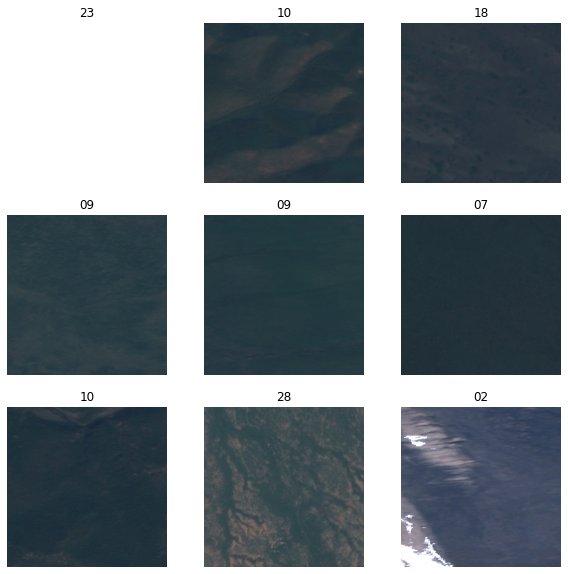

In [5]:
## Mostramos las 9 primeras imagenes de training
class_names = training.class_names
plt.figure(figsize=(10, 10))
for images, labels in training.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
## Función que muestra la evolución de las accuracy de train y validacion
## durante el entrenamiento.
def mostrarEvolucion(hist):

  loss = hist.history['loss']
  val_loss = hist.history['val_loss']
  plt.plot(loss)
  plt.plot(val_loss)
  plt.legend(['Training loss', 'Validation loss'])
  plt.show()

  acc = hist.history['accuracy']
  val_acc = hist.history['val_accuracy']
  plt.plot(acc)
  plt.plot(val_acc)
  plt.legend(['Training accuracy', 'Validation accuracy'])
  plt.show()


In [61]:

## Vamos a entrenar usando la red InceptionV3
base_model = tf.keras.applications.InceptionV3(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet',
                                               pooling = "avg")

base_model.trainable = False

normalization = Rescaling(1./255)
prediction_layer = Dense(29, activation = "softmax")

model = Sequential([
  normalization,
  base_model,
  prediction_layer
])


opt = Adam()
      
model.compile(loss=SparseCategoricalCrossentropy(from_logits=False),optimizer=opt, 
                  metrics=['accuracy'])

mlflow.set_experiment("Prueba")
mlflow.tensorflow.autolog()

with mlflow.start_run():
  callback = EarlyStopping(patience=3,restore_best_weights=True)
  history = model.fit(training,
                        epochs=10,
                        validation_data=validation,
                        callbacks=callback)

  mostrarEvolucion(history)

Epoch 1/10
 10/257 [>.............................] - ETA: 44s - loss: 3.3778 - accuracy: 0.0719

2022/03/10 11:06:21 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


KeyboardInterrupt: ignored

In [8]:
## Predecimos las clases
y_pred = model.predict(test)
classes = np.argmax(y_pred, axis=1)
classes = np.array(classes)
classes = classes + 1
print(classes)

[10 10 10 ...  9 12 17]


In [9]:
## Creamos el csv con los resultados
d = {'id.jpg': sorted(os.listdir("Sentinel2LULC_Test")), 'label': classes}
df = pd.DataFrame(data=d)
df.to_csv('resultados.csv', index=False)

In [73]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32

train_image_generator = ImageDataGenerator(rotation_range = 360, # en este problema tiene sentido que la imagen pueda ser tomada desde cualquier angulo
                                           zoom_range = 0.3,
                                           horizontal_flip = True,
                                           vertical_flip = True,
                                           brightness_range = (0.2, 1.0),
                                           width_shift_range = 0.2,
                                           height_shift_range = 0.2,
                                           validation_split = 0.2)


training_generator = train_image_generator.flow_from_directory(
  "Sentinel2LULC_354",
  subset="training",
  seed=1234,
  target_size=(224, 224),
  batch_size = batch_size,
  class_mode='sparse')


validation_generator = train_image_generator.flow_from_directory(
  "Sentinel2LULC_354",
  subset="validation",
  seed=1234,
  target_size=(224, 224),
  batch_size = batch_size,
  class_mode='sparse')

total_train = 8236
total_val = 2030

Found 8236 images belonging to 29 classes.
Found 2030 images belonging to 29 classes.


Epoch 1/10
257/257 [==============================] - 176s 663ms/step - loss: 2.0486 - accuracy: 0.4024 - val_loss: 1.8161 - val_accuracy: 0.4573
Epoch 2/10
257/257 [==============================] - 166s 647ms/step - loss: 1.5211 - accuracy: 0.5256 - val_loss: 1.7026 - val_accuracy: 0.4916
Epoch 3/10
257/257 [==============================] - 166s 646ms/step - loss: 1.4113 - accuracy: 0.5567 - val_loss: 1.7291 - val_accuracy: 0.4697
Epoch 4/10
257/257 [==============================] - 163s 633ms/step - loss: 1.3269 - accuracy: 0.5790 - val_loss: 1.5744 - val_accuracy: 0.5218
Epoch 5/10
257/257 [==============================] - 178s 691ms/step - loss: 1.2899 - accuracy: 0.5890 - val_loss: 1.5064 - val_accuracy: 0.5347
Epoch 6/10
257/257 [==============================] - 163s 634ms/step - loss: 1.2530 - accuracy: 0.5954 - val_loss: 1.5550 - val_accuracy: 0.5312
Epoch 7/10
257/257 [==============================] - 163s 636ms/step - loss: 1.2172 - accuracy: 0.6025 - val_loss: 1.5066 -

2022/03/10 11:45:29 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during tensorflow autologging: 'EarlyStopping' object is not iterable


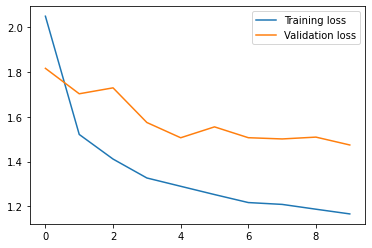

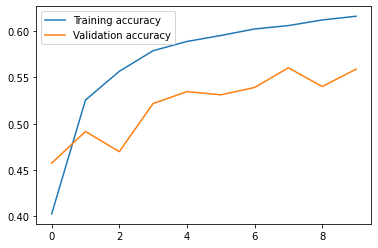

In [74]:
## Vamos a entrenar usando la red InceptionV3
base_model = tf.keras.applications.InceptionV3(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet',
                                               pooling = "avg")

base_model.trainable = False

normalization = Rescaling(1./255)
prediction_layer = Dense(29, activation = "softmax")

model = Sequential([
  normalization,
  base_model,
  prediction_layer
])


opt = Adam()
      
model.compile(loss= SparseCategoricalCrossentropy(from_logits = False), optimizer=opt, 
                  metrics=['accuracy'])

mlflow.set_experiment("Prueba_data_augmentation")
mlflow.tensorflow.autolog()

# a partir de TF 2.2, fit ya funciona con generadores, no hace falta usar fit_generator
with mlflow.start_run():
  callback = EarlyStopping(patience=3,restore_best_weights=True)
  history = model.fit(training_generator,
                        epochs=10,
                        steps_per_epoch = total_train // batch_size, # si queremos usar más imágenes, aumentar este parametro y validation_steps
                        validation_data = validation_generator,
                        validation_steps = total_val // batch_size,
                        callbacks=callback)

  mostrarEvolucion(history)

In [75]:
## Predecimos las clases
y_pred = model.predict(test)
classes = np.argmax(y_pred, axis=1)
classes = np.array(classes)
classes = classes + 1
print(classes)

[10  6  6 ... 21 12 16]


In [76]:
## Creamos el csv con los resultados
d = {'id.jpg': sorted(os.listdir("Sentinel2LULC_Test")), 'label': classes}
df = pd.DataFrame(data=d)
df.to_csv('inceptionv3_congelado_data_augmentation.csv', index=False)